In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *
from worm_env import *

In [2]:
env = ProcessedWorm(0,ep_len=1e6) # Input is target angle

In [12]:
obs,rew,done,info = env.step(env.action_space.sample())

In [17]:
env.action_space.sample()

1

{'loc': array([ 938.54285714, 1138.9       ]), 'img': array([[3, 0, 1, ..., 1, 5, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 2, 2, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 1, 1],
       [1, 3, 0, ..., 0, 0, 2],
       [1, 2, 0, ..., 0, 0, 0]], dtype=uint8), 'scores': array([114300, 128025]), 'angs': array([ 60, 270]), 'endpts': array([[ 940,  937],
       [1130, 1149]]), 'body': 60}


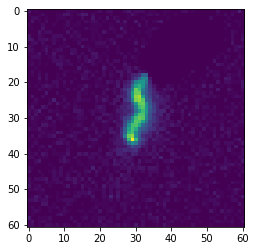

In [13]:
env.render()

In [3]:
env.close()

In [2]:
env = ProcessedWorm(0,ep_len=60)
for i_episode in range(2):
    done = False
    t=0
    while not done:
        t += 1
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(f'Body and head: {observation} \t\t\r',end='')
    print("Episode finished after {} timesteps".format(t+1))
    observation = env.reset(target=(1+i_episode)*180)
env.close()

Episode finished after 201 timesteps
Episode finished after 201 timesteps
